In [10]:
%load_ext autoreload
%autoreload 2
%matplotlib widget

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [11]:
import numpyro

NDEVICES = 16
numpyro.set_host_device_count(NDEVICES)

In [12]:
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.lines import Line2D
import seaborn as sns
import os
from datetime import date, timedelta
from tqdm.auto import tqdm
from collections import defaultdict
import itertools

import numpy as np
import pandas as pd
import jax.numpy as jnp
from jax.random import PRNGKey

import numpyro.distributions as dist
from numpyro.infer import MCMC, NUTS, Predictive

import mechafil_jax.data as data
import mechafil_jax.sim as sim
import mechafil_jax.constants as C
import mechafil_jax.minting as minting
import mechafil_jax.plot_utils as pu
import mechafil_jax.date_utils as du

import scenario_generator.utils as u
import scenario_generator.curated as curated
import scenario_generator.mcmc_forecast as mcmc

import pystarboard.data

from cel_utils import disk_utils

In [13]:
token = os.path.join(os.environ['HOME'],'code/cel/auth/spacescope_auth.json')
print(os.path.exists(token))

mcmc_train_len_days = 90
# current_date = date(2024, 1, 8)

current_date = date.today() - timedelta(days=3)
start_date = current_date - timedelta(days=3) # get some historical data
current_day = (current_date-start_date).days
forecast_length = int(365*1.5)
end_date = current_date + timedelta(days=forecast_length)
print(start_date, current_date, end_date)

True
2024-01-16 2024-01-19 2025-07-19


In [14]:
# MCMC forecasting configuration
mcmc_train_start_date = current_date - timedelta(days=(mcmc_train_len_days))
mcmc_train_end_date = mcmc_train_start_date + timedelta(days=mcmc_train_len_days)
num_warmup_mcmc = 5000
num_samples_mcmc = 5000
seasonality_mcmc = 2000
num_chains_mcmc = 8

In [21]:
pystarboard.data.setup_spacescope(token)
# get historical data used for forecasting FIL+ rate
x_rb_onboard_train, y_rb_onboard_train = u.get_historical_daily_onboarded_power(
    mcmc_train_start_date, 
    mcmc_train_end_date
)
x_deal_onboard_train, y_deal_onboard_train = u.get_historical_deals_onboard(
    mcmc_train_start_date, 
    mcmc_train_end_date
)

In [22]:
train_start_date = pd.to_datetime(max(x_deal_onboard_train.values[0], x_rb_onboard_train.values[0]))
train_end_date = pd.to_datetime(min(x_deal_onboard_train.values[-1], x_rb_onboard_train.values[-1]))

ii_start = np.where(train_start_date==x_rb_onboard_train.values)[0][0]
ii_end = np.where(train_end_date==x_rb_onboard_train.values)[0][0]
x_rb_onboard_train = x_rb_onboard_train[ii_start:ii_end]
y_rb_onboard_train = y_rb_onboard_train[ii_start:ii_end]

ii_start = np.where(train_start_date==x_deal_onboard_train.values)[0][0]
ii_end = np.where(train_end_date==x_deal_onboard_train.values)[0][0]
x_deal_onboard_train = x_deal_onboard_train[ii_start:ii_end]
y_deal_onboard_train = y_deal_onboard_train[ii_start:ii_end]

In [25]:
bias = 0
y_cc_onboard_train = jnp.clip(jnp.array(y_rb_onboard_train - y_deal_onboard_train)+bias, a_min=0.001)


In [26]:
y_cc_onboard_scale = 1
cc_onboard_pred, cc_onboard_pred_rhats = mcmc.mcmc_predict((y_cc_onboard_train)/y_cc_onboard_scale, forecast_length,
                                num_warmup_mcmc=num_warmup_mcmc, 
                                num_samples_mcmc=num_samples_mcmc,
                                seasonality_mcmc=seasonality_mcmc, 
                                num_chains_mcmc=num_chains_mcmc,
                                verbose=True)
cc_onboard_pred *= y_cc_onboard_scale
cc_onboard_pred -= bias

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]


                      mean       std    median      5.0%     95.0%     n_eff     r_hat
      coef_trend     -0.28      0.61      0.00     -1.74      0.18       nan     63.58
       init_s[0]      0.10      0.71      0.11     -1.15      1.21      4.72      3.02
       init_s[1]     -0.04      0.42      0.02     -1.02      0.50      4.40      3.81
       init_s[2]     -0.01      0.30      0.02     -0.67      0.42      4.61      3.11
       init_s[3]      0.46      0.69      0.12     -0.08      1.75      4.20      5.16
       init_s[4]     -0.29      0.62     -0.10     -1.88      0.11      4.16      5.42
       init_s[5]     -0.59      0.69     -0.35     -1.93      0.03      4.22      4.98
       init_s[6]      0.29      0.73      0.50     -1.46      0.95      4.76      2.84
       init_s[7]     -0.08      0.66      0.02     -1.61      0.92      4.15      5.60
       init_s[8]     -0.20      0.43     -0.06     -1.22      0.19      4.44      3.91
       init_s[9]      0.26      0.57      

In [19]:
mcmc.check_rhat(cc_onboard_pred_rhats, 1.05)

0.0

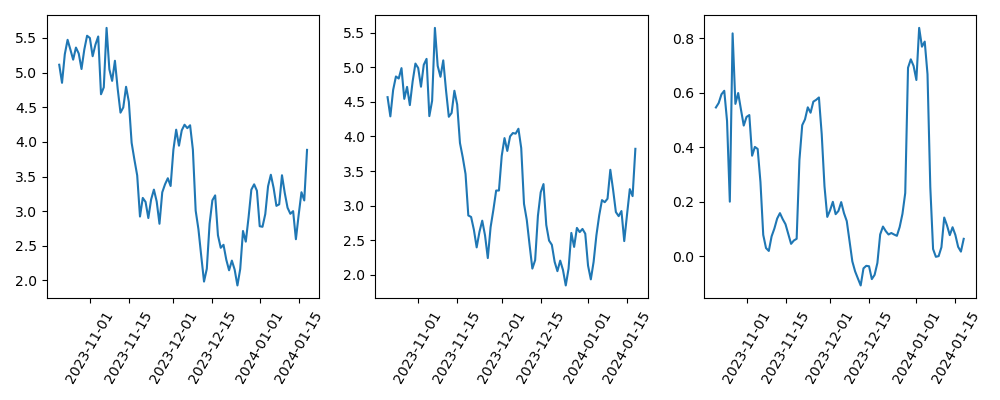

In [20]:
plt.figure(figsize=(10,4))

plt.subplot(1,3,1)
plt.plot(x_rb_onboard_train, y_rb_onboard_train)
plt.xticks(rotation=60)

plt.subplot(1,3,2)
plt.plot(x_deal_onboard_train, y_deal_onboard_train)
plt.xticks(rotation=60)

plt.subplot(1,3,3)
plt.plot(x_deal_onboard_train, y_rb_onboard_train-y_deal_onboard_train)
plt.xticks(rotation=60)

plt.tight_layout()